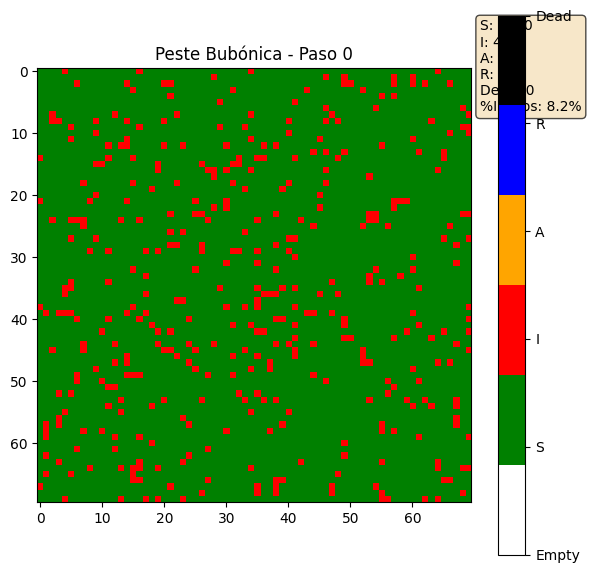

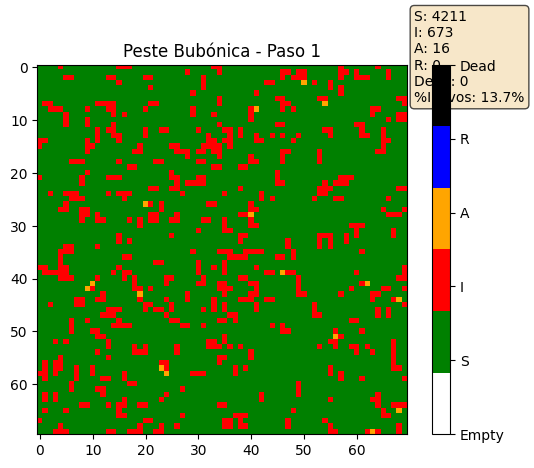

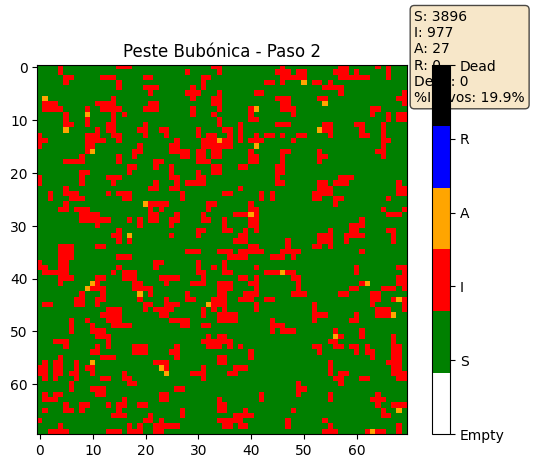

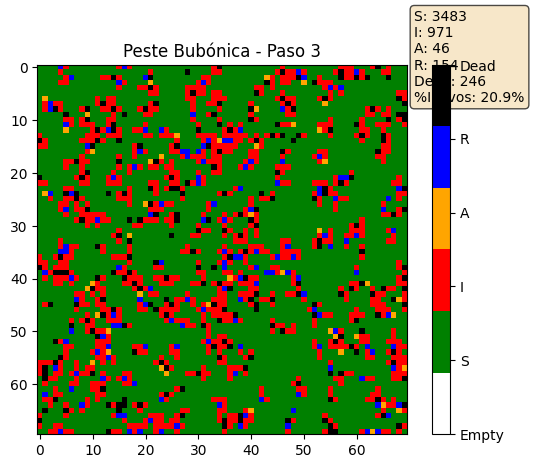

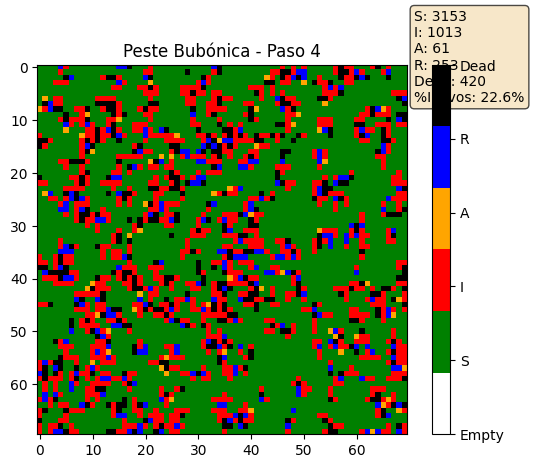

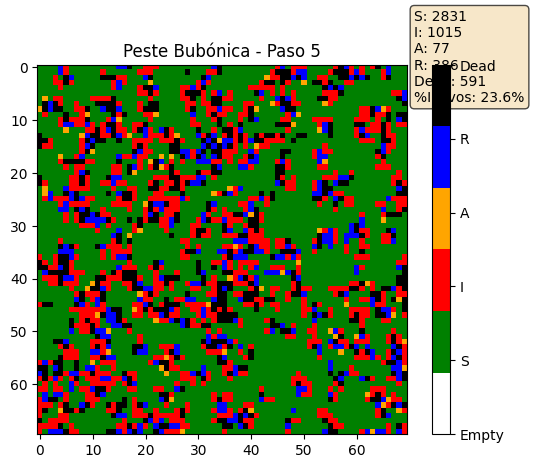

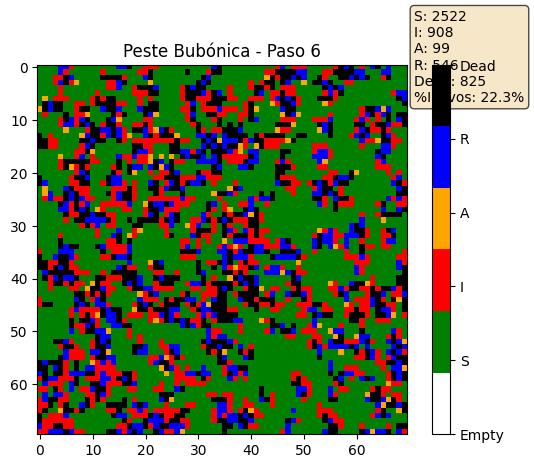

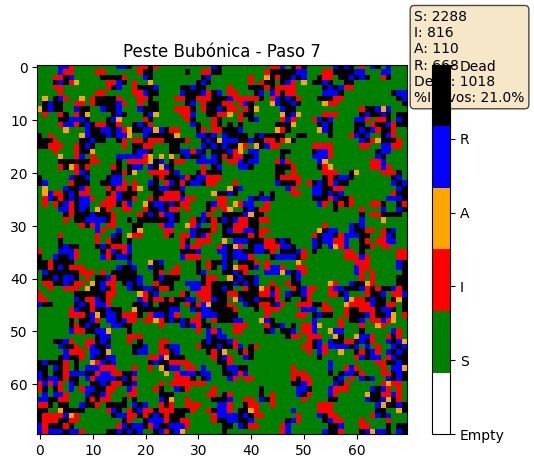

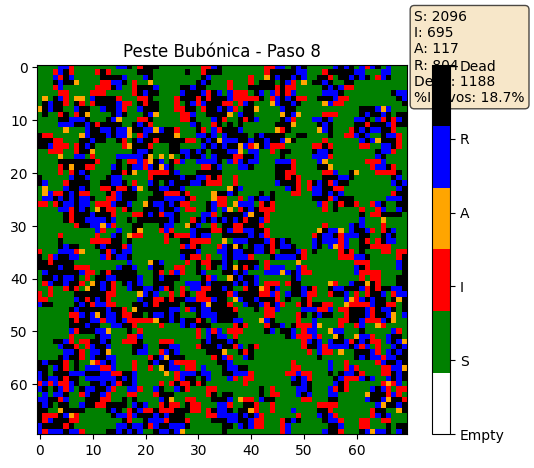

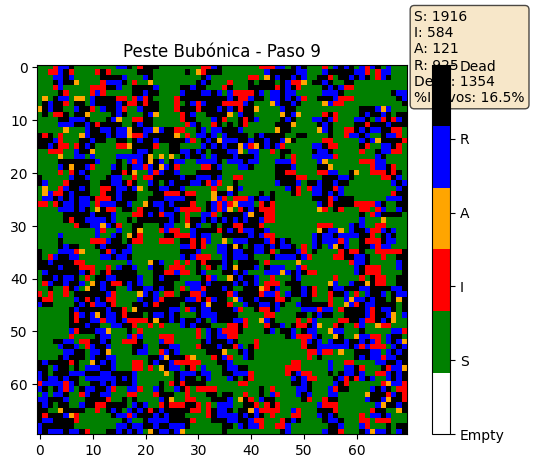

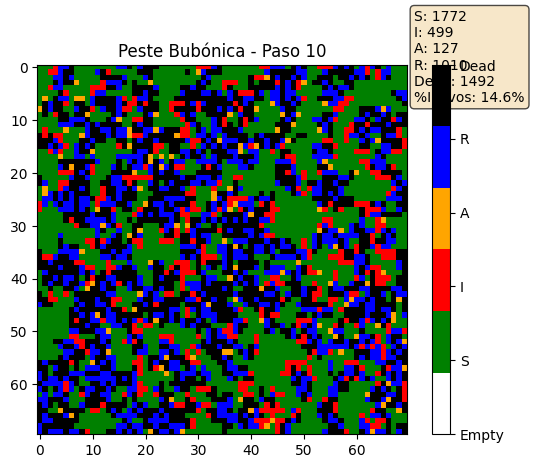

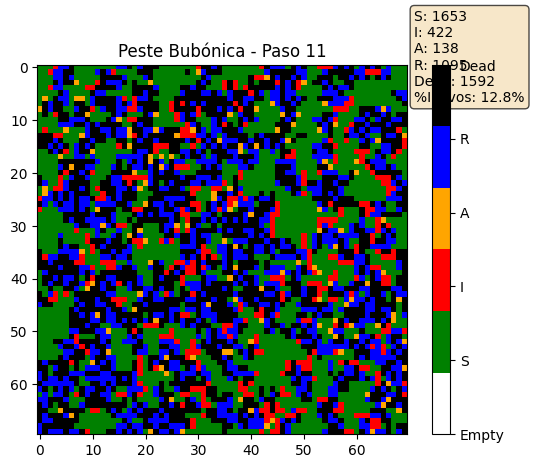

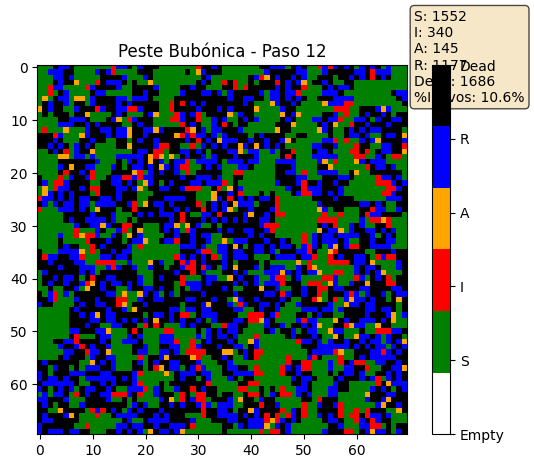

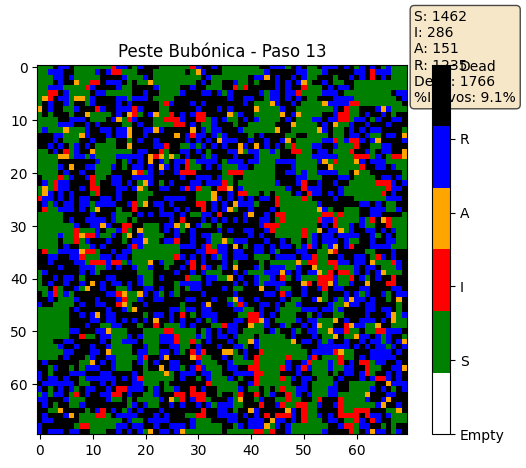

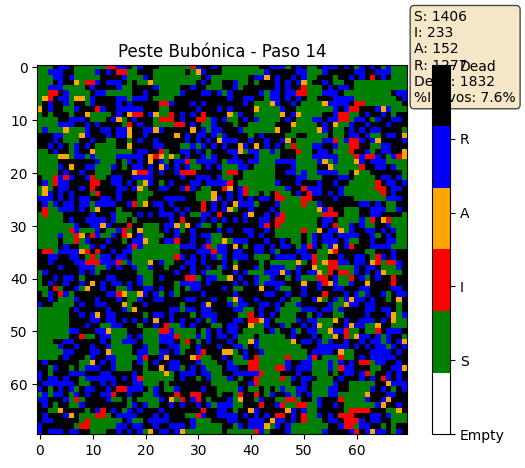

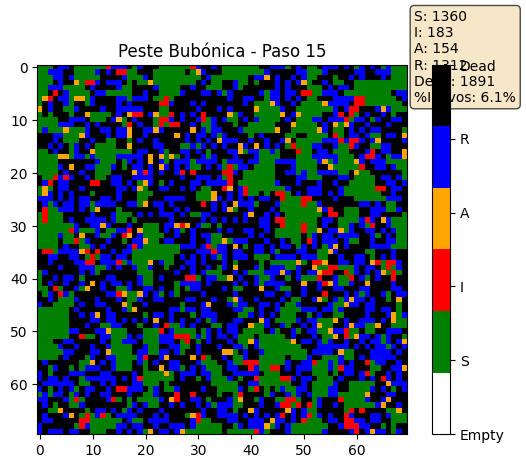

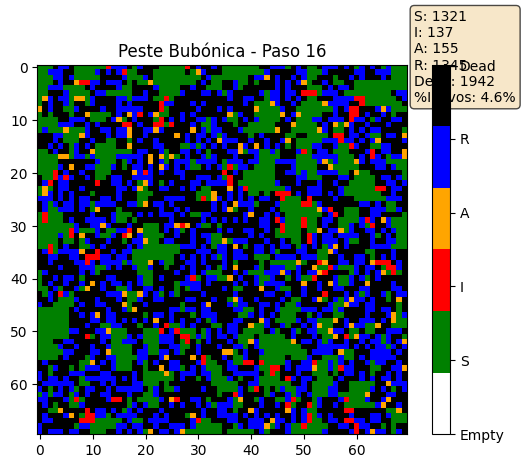

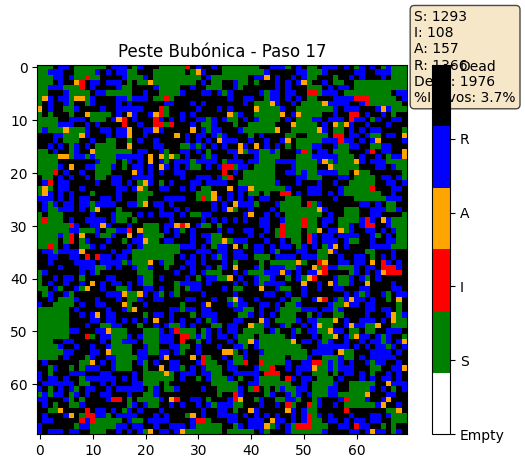

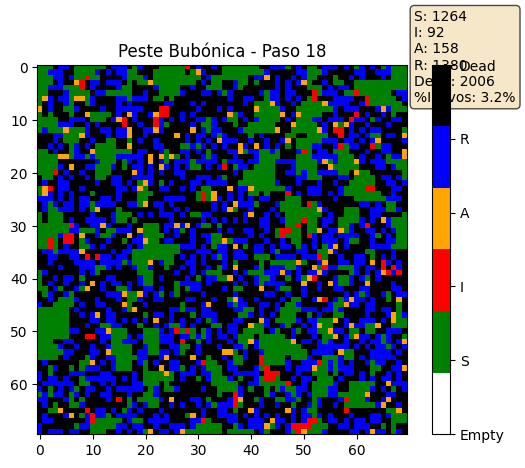

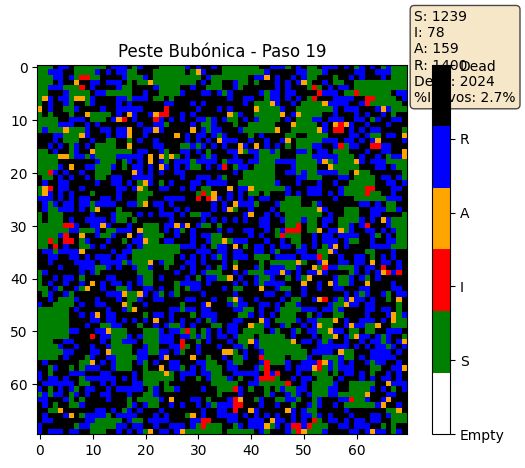

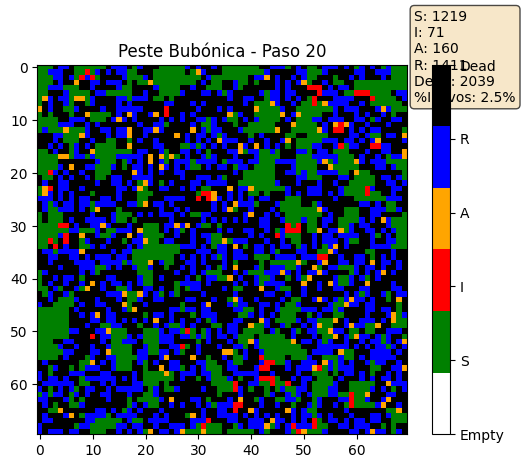

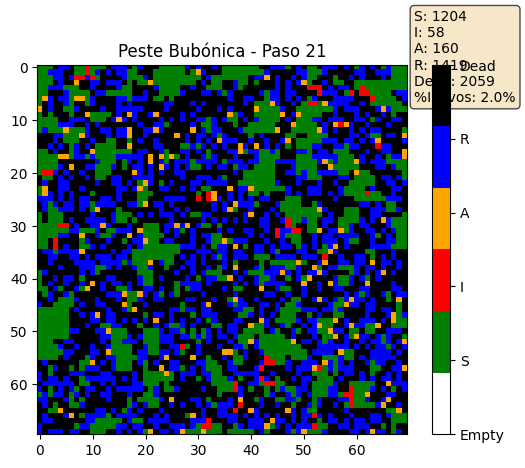

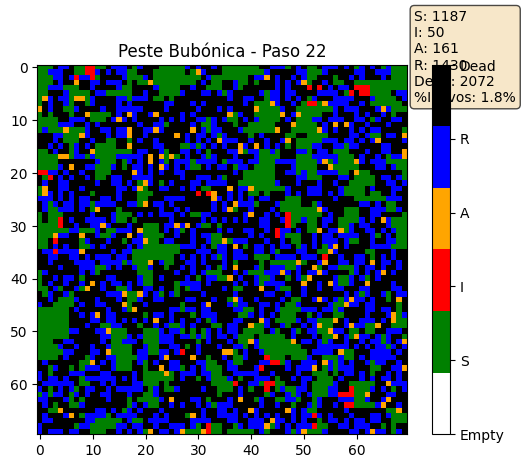

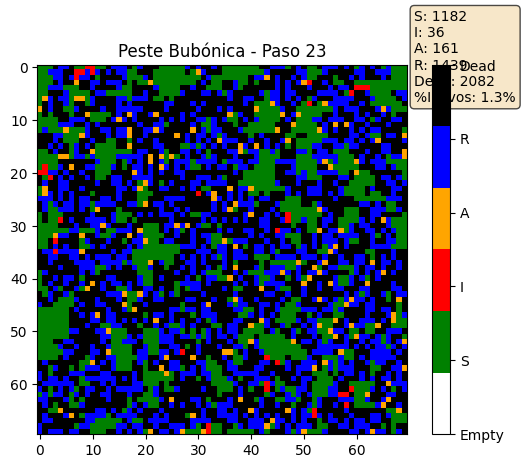

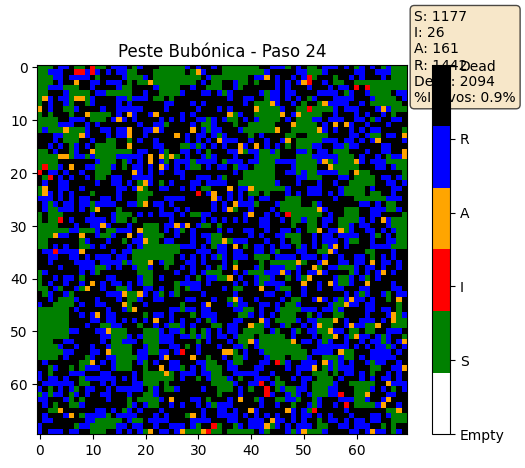

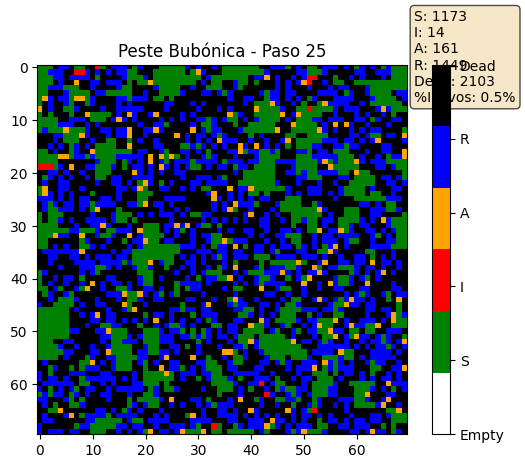

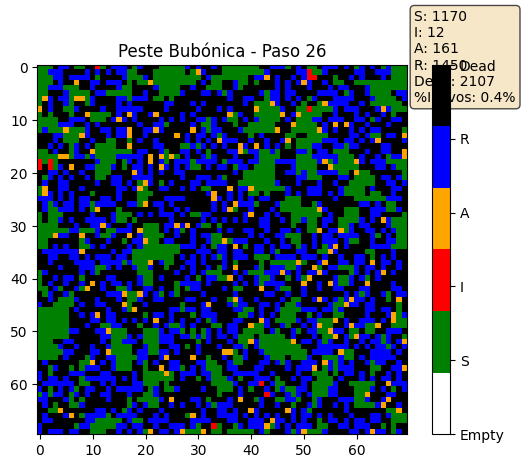

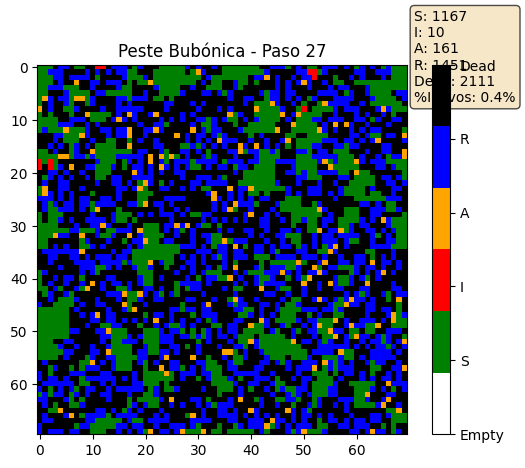

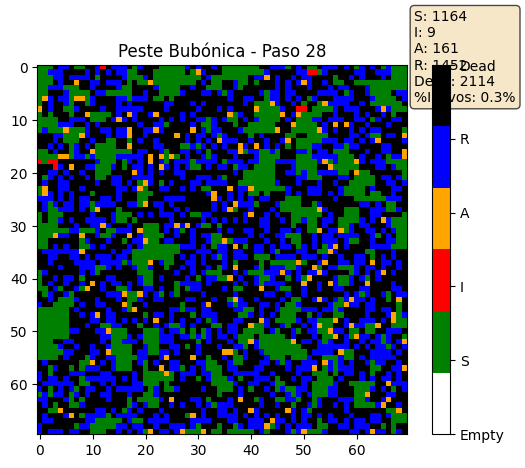

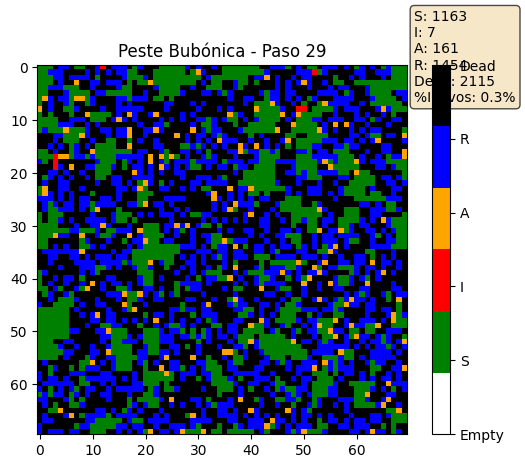

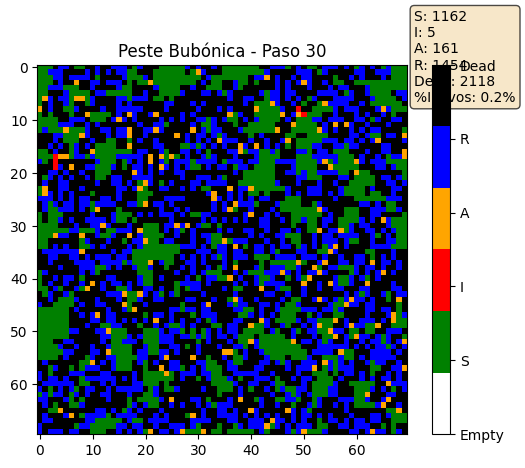

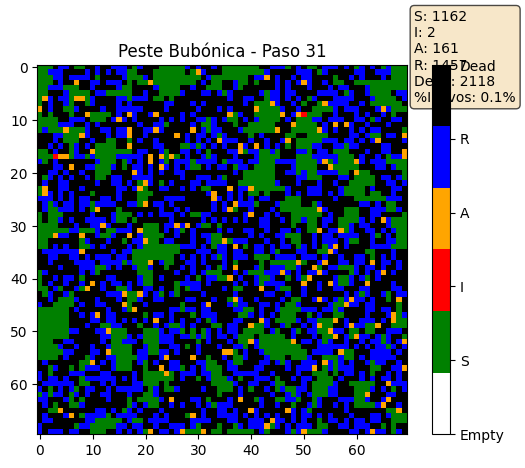

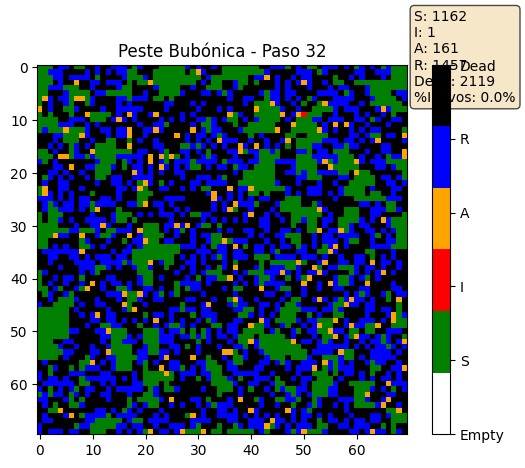

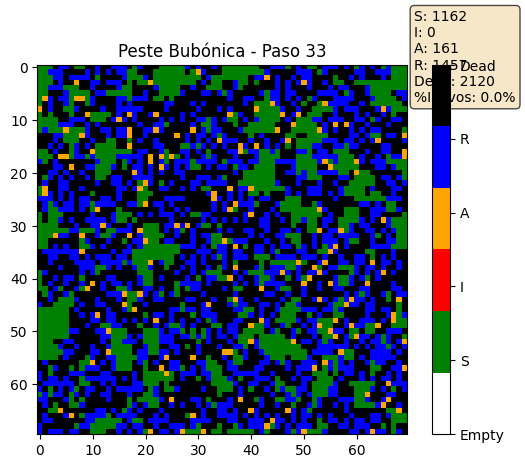

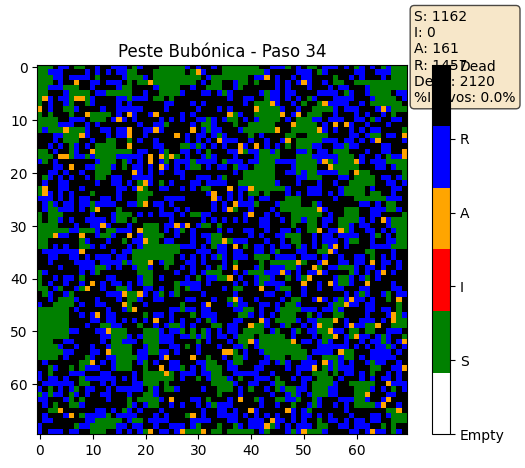

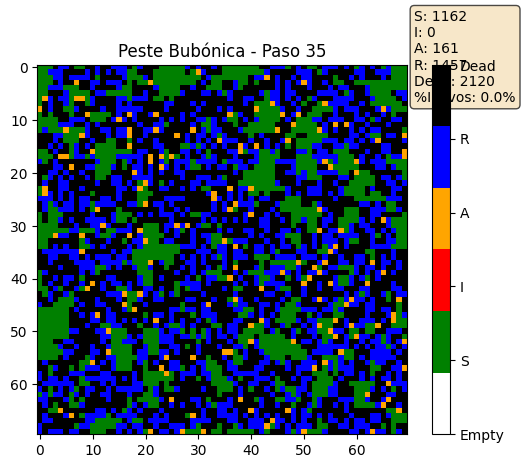

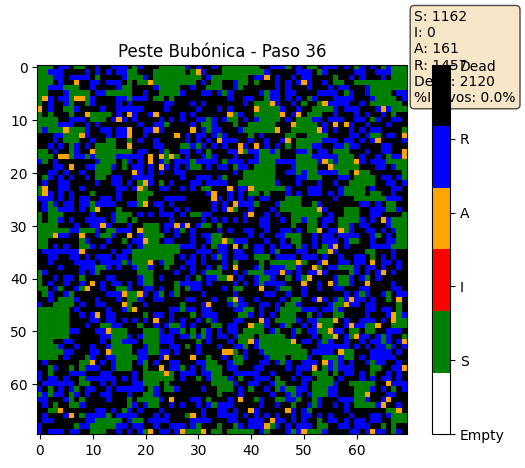

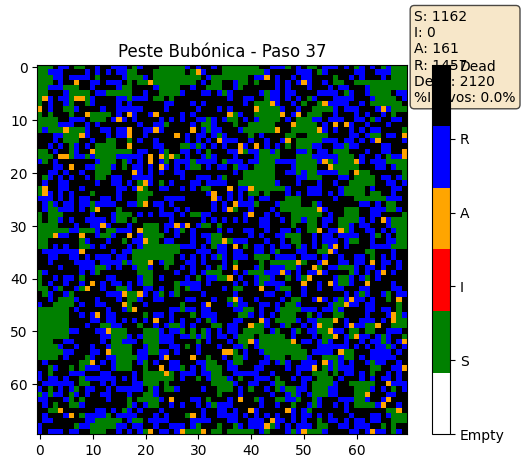

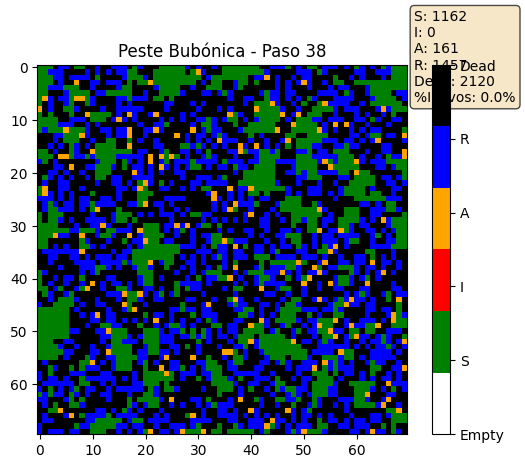

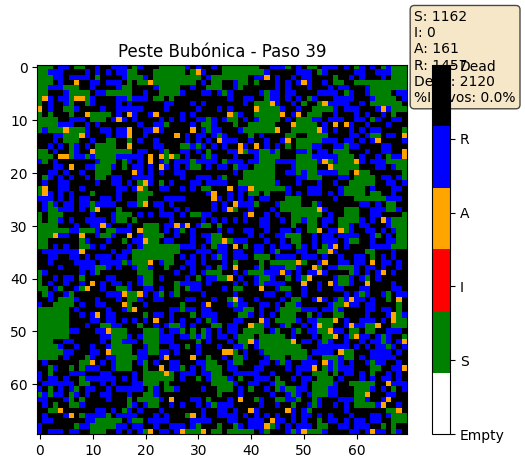

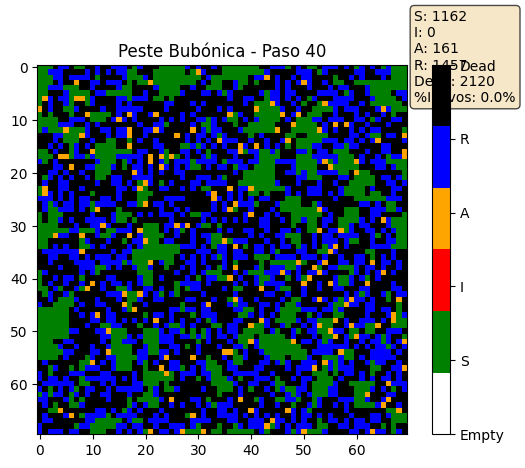

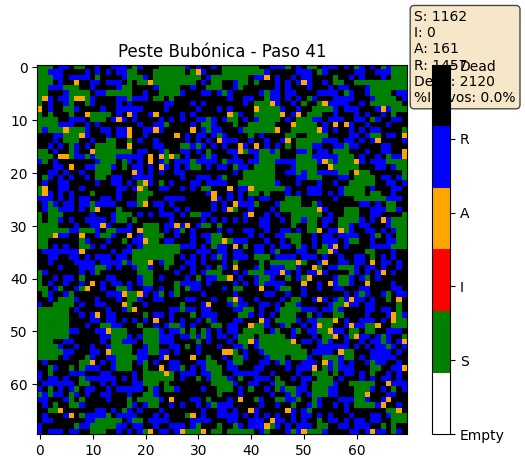

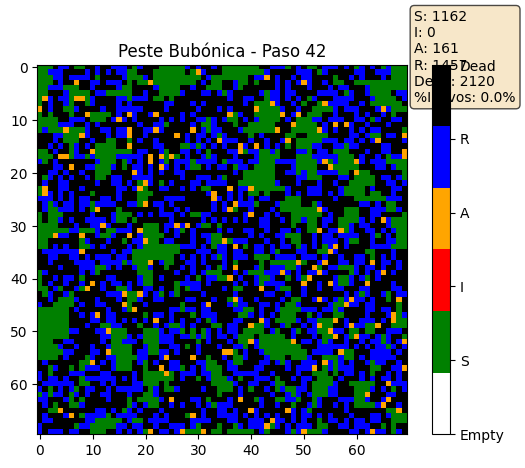

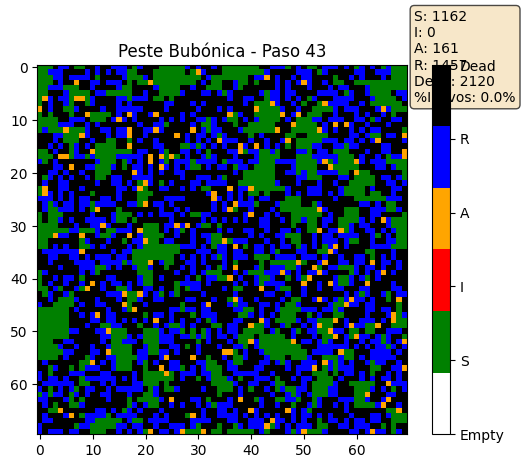

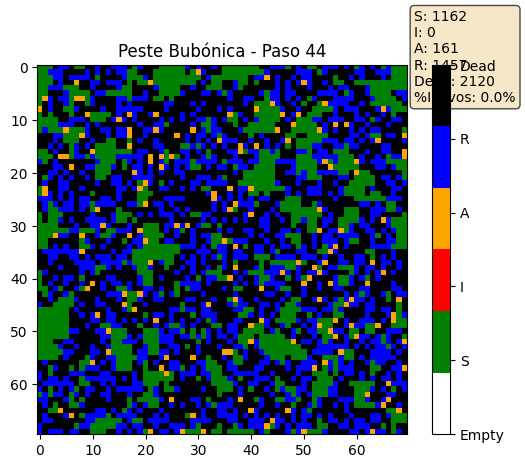

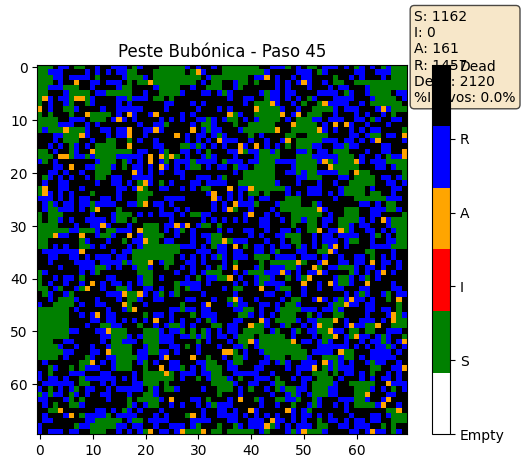

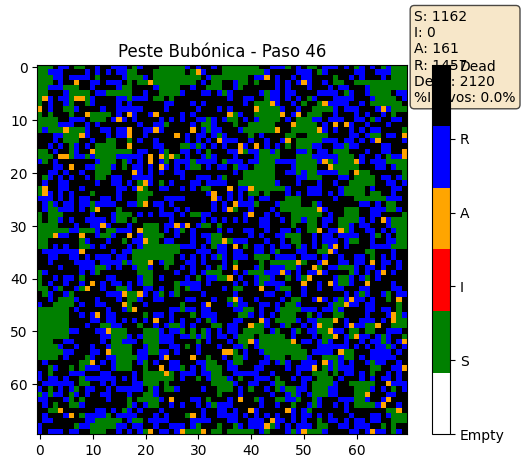

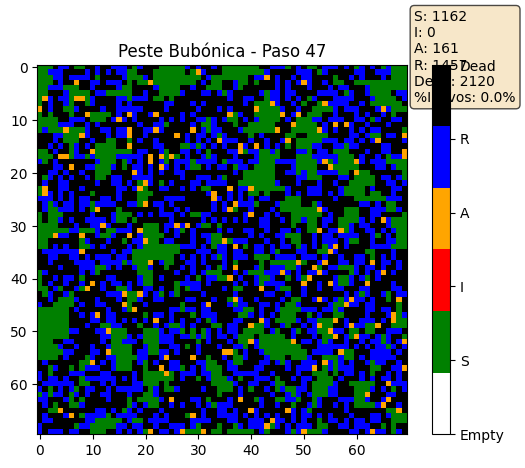

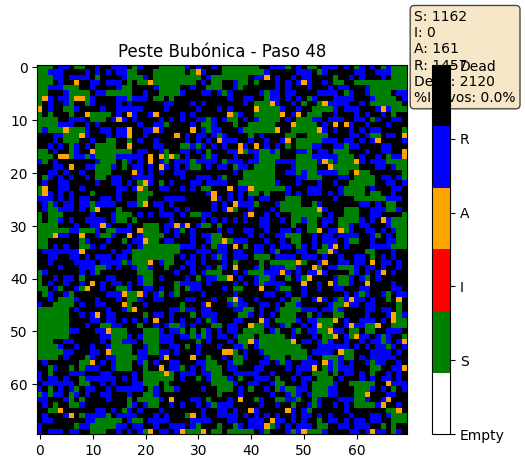

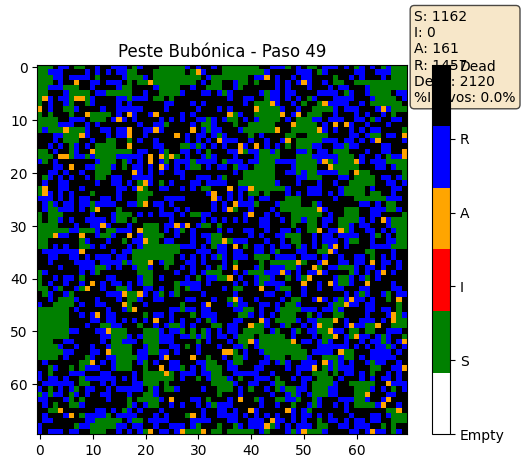

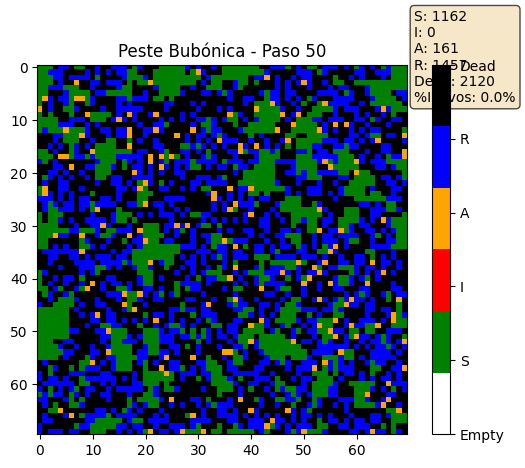

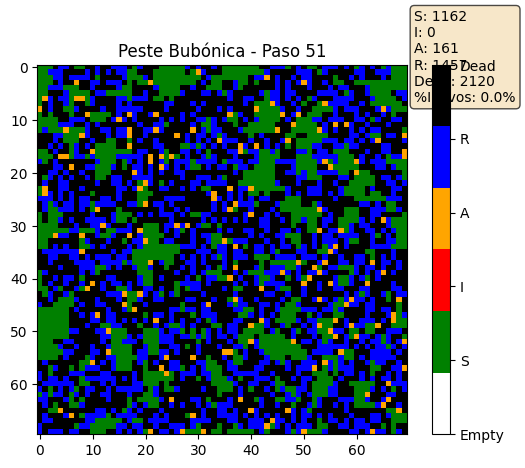

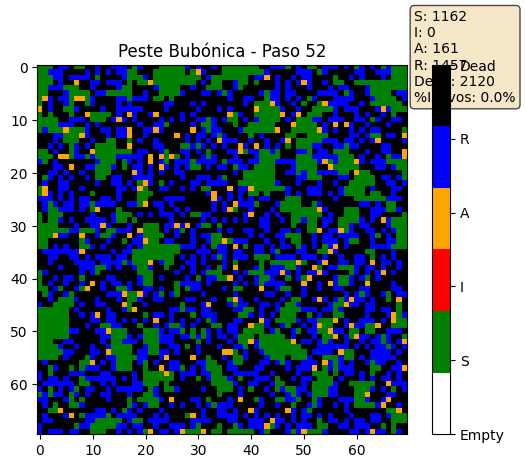

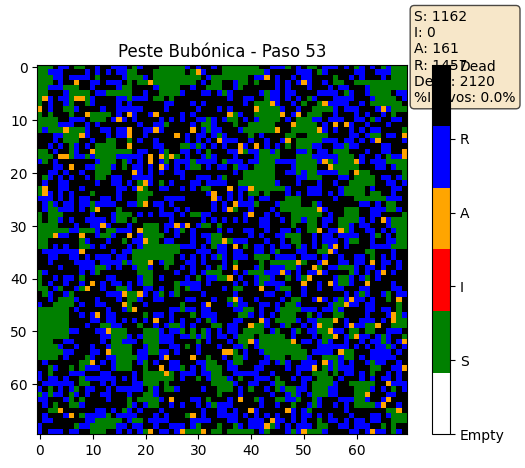

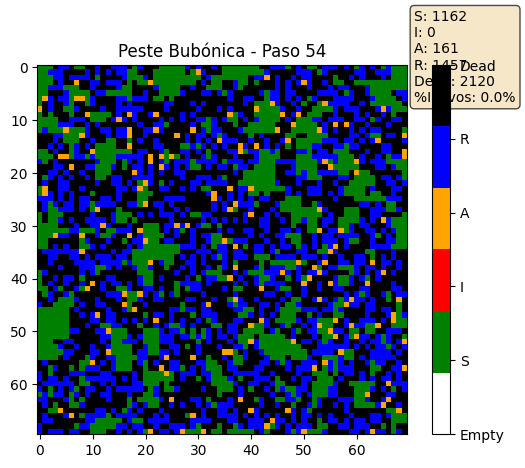

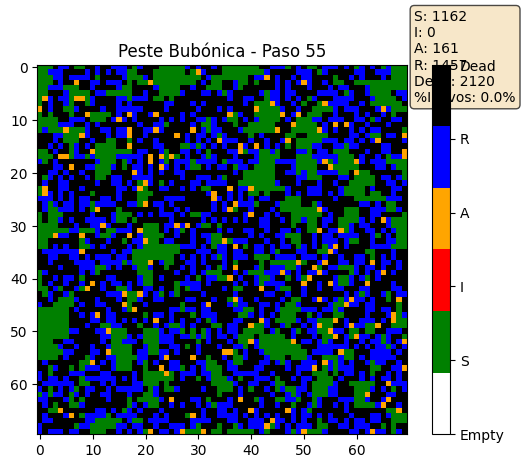

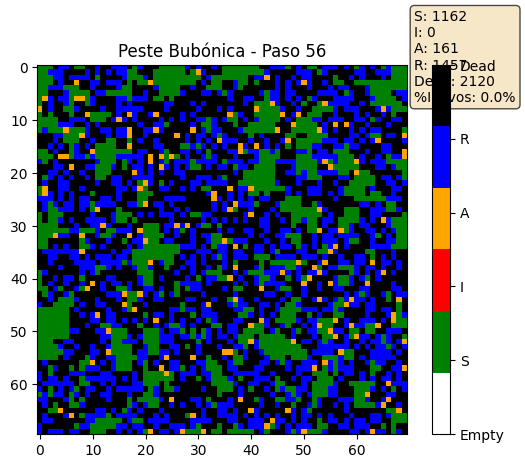

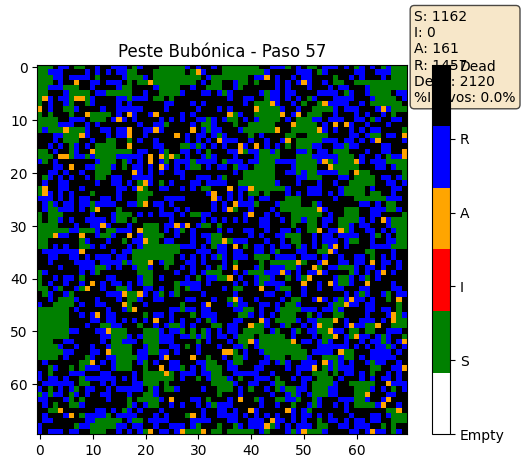

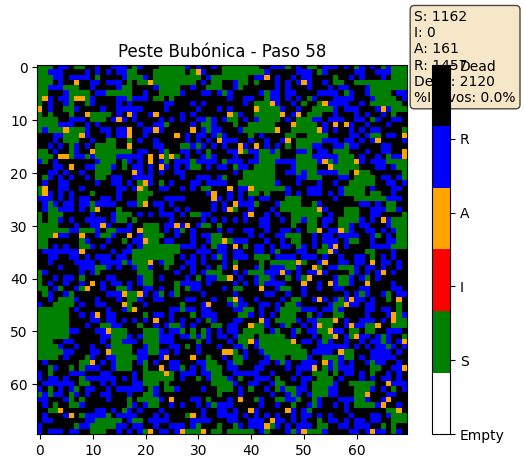

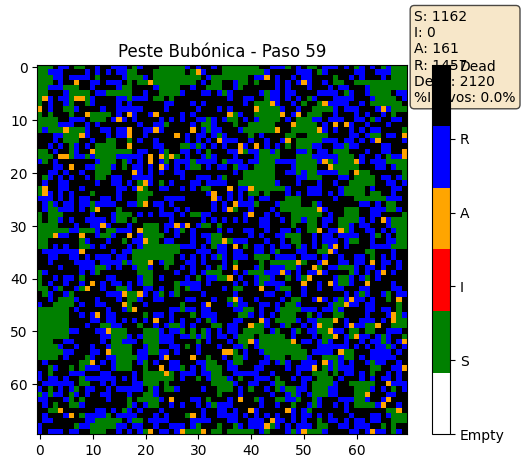

KeyboardInterrupt: 

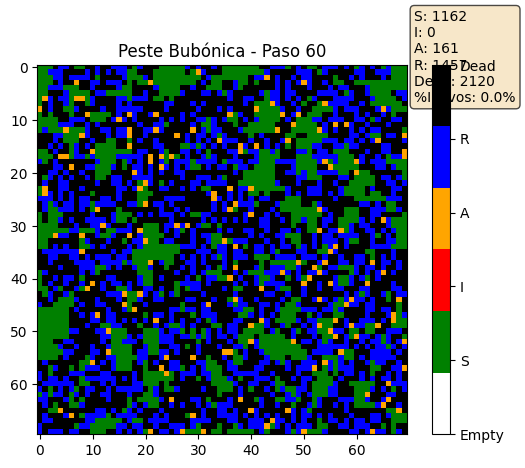

In [2]:
# ===============================
# MODELO AC - PESTE BUBÓNICA
# ===============================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ----------------- Estados -----------------
EMPTY = 0
SUS = 1      # Sano
INF = 2      # Infectado
ASY = 3      # Asintomático permanente
REC = 4      # Recuperado
DEAD = 5     # Muerto

# ----------------- Parámetros -----------------
SIZE = 70
infectious_period = 3
p_trans = 0.2
p_asym = 0.05
mortality_prob = 0.6
move_prob = 0.1

np.random.seed(42)

# ----------------- Inicialización -----------------

def initialize_grid():
    grid = np.zeros((SIZE, SIZE), dtype=int)
    timer = np.zeros((SIZE, SIZE), dtype=int)

    total_cells = SIZE * SIZE

    # colocar 4500 sanos
    sus_indices = np.random.choice(total_cells, 4500, replace=False)
    for idx in sus_indices:
        i = idx // SIZE
        j = idx % SIZE
        grid[i,j] = SUS

    # colocar 400 infectados
    remaining = list(set(range(total_cells)) - set(sus_indices))
    inf_indices = np.random.choice(remaining, 400, replace=False)
    for idx in inf_indices:
        i = idx // SIZE
        j = idx % SIZE
        grid[i,j] = INF
        timer[i,j] = infectious_period

    return grid, timer

# ----------------- Vecindad von Neumann -----------------

def neighbors(i,j):
    for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
        ni, nj = i+di, j+dj
        if 0 <= ni < SIZE and 0 <= nj < SIZE:
            yield ni, nj

# ----------------- Actualización -----------------

def update(grid, timer):
    new_grid = grid.copy()
    new_timer = timer.copy()

    for i in range(SIZE):
        for j in range(SIZE):
            state = grid[i,j]

            # ----------- SANO -----------
            if state == SUS:
                infected_neighbors = 0
                for ni,nj in neighbors(i,j):
                    if grid[ni,nj] == INF:
                        infected_neighbors += 1

                # probabilidad acumulada
                p_no_inf = (1 - p_trans)**infected_neighbors
                p_inf = 1 - p_no_inf

                if np.random.rand() < p_inf:
                    if np.random.rand() < p_asym:
                        new_grid[i,j] = ASY
                    else:
                        new_grid[i,j] = INF
                        new_timer[i,j] = infectious_period

            # ----------- INFECTADO -----------
            elif state == INF:
                new_timer[i,j] -= 1
                if new_timer[i,j] <= 0:
                    if np.random.rand() < mortality_prob:
                        new_grid[i,j] = DEAD
                    else:
                        new_grid[i,j] = REC

            # ----------- MOVIMIENTO -----------
            if state in [SUS, INF, ASY, REC]:
                if np.random.rand() < move_prob:
                    possible_moves = []
                    for ni,nj in neighbors(i,j):
                        if grid[ni,nj] == EMPTY:
                            possible_moves.append((ni,nj))
                    if possible_moves:
                        ni,nj = possible_moves[np.random.randint(len(possible_moves))]
                        new_grid[ni,nj] = new_grid[i,j]
                        new_timer[ni,nj] = new_timer[i,j]
                        new_grid[i,j] = EMPTY
                        new_timer[i,j] = 0

    return new_grid, new_timer

# ----------------- Animación -----------------

def simulate(steps=100, pause=0.1):
    grid, timer = initialize_grid()

    colors = ['white','green','red','orange','blue','black']
    cmap = ListedColormap(colors)

    initial_population = np.count_nonzero(grid != EMPTY)

    plt.figure(figsize=(7,7))

    for t in range(steps):
        sus = np.sum(grid == SUS)
        inf = np.sum(grid == INF)
        asy = np.sum(grid == ASY)
        rec = np.sum(grid == REC)
        dead = np.sum(grid == DEAD)

        living = sus + inf + asy + rec
        if living > 0:
            p_inf = inf/living*100
        else:
            p_inf = 0

        plt.clf()
        plt.imshow(grid, cmap=cmap, vmin=0, vmax=5)
        plt.title(f"Peste Bubónica - Paso {t}")
        plt.colorbar(ticks=[0,1,2,3,4,5]).ax.set_yticklabels(
            ['Empty','S','I','A','R','Dead'])

        info = (
            f"S: {sus}\n"
            f"I: {inf}\n"
            f"A: {asy}\n"
            f"R: {rec}\n"
            f"Dead: {dead}\n"
            f"%I vivos: {p_inf:.1f}%"
        )

        plt.gca().text(1.02,0.9,info,transform=plt.gca().transAxes,
                       bbox=dict(boxstyle="round",fc="wheat",alpha=0.7))

        plt.pause(pause)

        grid, timer = update(grid, timer)

    plt.show()

simulate(steps=120)